In [19]:
# =====================================
# 03_backtest_pairs.ipynb
# Backtest d'une stratégie de pairs trading
# =====================================

# Ce notebook évalue la performance des paires sélectionnées à l'étape 2.
# Il reconstruit le spread, le z-score et simule une stratégie simple
# avec entrée/sortie basée sur des seuils de z-score.

# -------------------------------------
# Paramètres globaux
# -------------------------------------
PAIRS_PATH = "../data/processed/pair_selection/pairs_results.parquet"  # Résultats de la partie 2
PRICES_PATH = "../data/processed/close_1h.parquet"  # Historique des prix (même base)
OUTPUT_DIR = "../data/processed/backtest_results"

# Paramètres stratégiques
ZSCORE_ENTRY = 2.0     # seuil d'entrée (|z| >= 2)
ZSCORE_EXIT = 0.5      # seuil de sortie (|z| <= 0.5)
LOOKBACK_ZSCORE = 480    # fenêtre de calcul de la moyenne/écart-type du spread
CAPITAL_PER_TRADE = 1_000_000  # notionnel par paire
TRANSACTION_COST_BPS = 5       # coût aller-retour (en basis points)


In [20]:
# =====================================
# Chargement des données et préparation
# =====================================

import pandas as pd
from pathlib import Path

# Création du dossier de sortie
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Chargement des prix
prices = pd.read_parquet(PRICES_PATH)
prices.index = pd.to_datetime(prices.index, utc=True, errors="coerce")
prices = prices.sort_index().ffill().bfill()
print(f"✅ Données de prix chargées : {prices.shape[0]} observations, {prices.shape[1]} tickers.")

# Chargement des résultats de la partie 2
pairs_all = pd.read_parquet(PAIRS_PATH)
print(f"✅ {len(pairs_all)} paires analysées au total.")

# Filtrage : on garde uniquement les paires validées par FDR
pairs_valid = pairs_all.query("fdr_reject == True").copy()
if pairs_valid.empty:
    print("⚠️ Aucune paire validée FDR trouvée — on prendra le top 3 par p-value brute.")
    pairs_valid = pairs_all.sort_values("pvalue").head(3).copy()

print(f"➡️ {len(pairs_valid)} paires retenues pour backtest.")
display(pairs_valid[["ticker_a", "ticker_b", "pvalue", "half_life", "score"]])


✅ Données de prix chargées : 3494 observations, 9 tickers.
✅ 36 paires analysées au total.
⚠️ Aucune paire validée FDR trouvée — on prendra le top 3 par p-value brute.
➡️ 3 paires retenues pour backtest.


,ticker_a,ticker_b,pvalue,half_life,score
4,GS,JPM,0.010796,94.031172,2.081137
10,BK,GS,0.018519,126.489793,1.171768
7,JPM,WFC,0.034075,143.128790,1.480385


✅ Spread construit pour GS-JPM (α=-105.56, β=2.800)
✅ Spread construit pour BK-GS (α=1.09, β=0.137)
✅ Spread construit pour JPM-WFC (α=-5.01, β=3.588)


array([<Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>], dtype=object)

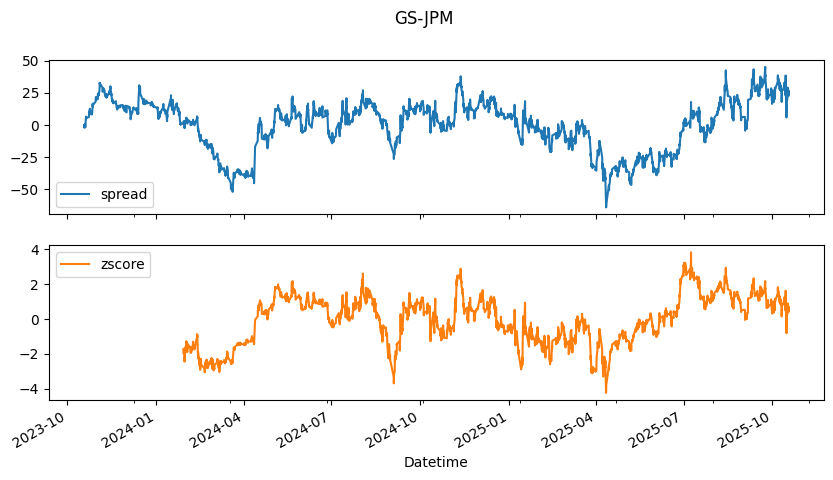

In [21]:
# =====================================
# Construction du spread OLS et du z-score
# =====================================

import pandas as pd
import numpy as np
import statsmodels.api as sm

def compute_spread_and_zscore(y, x, lookback=LOOKBACK_ZSCORE):
    """
    Calcule le spread OLS (y - (α + βx)) et son z-score glissant.
    Retourne un DataFrame avec colonnes ['spread', 'zscore'].
    """
    # --- Estimation OLS ---
    X = sm.add_constant(x.values)
    model = sm.OLS(y.values, X).fit()
    alpha, beta = model.params

    spread = y - (alpha + beta * x)

    # --- Z-score rolling ---
    mean = spread.rolling(lookback).mean()
    std = spread.rolling(lookback).std()
    zscore = (spread - mean) / std

    df = pd.DataFrame({
        "spread": spread,
        "zscore": zscore,
        "alpha": alpha,
        "beta": beta
    }, index=y.index)
    return df

# Construction pour chaque paire validée
spreads = {}
for _, row in pairs_valid.iterrows():
    a, b = row["ticker_a"], row["ticker_b"]
    if a not in prices.columns or b not in prices.columns:
        print(f"⚠️ Données manquantes pour {a}-{b}, ignoré.")
        continue

    df_sp = compute_spread_and_zscore(prices[a], prices[b], lookback=LOOKBACK_ZSCORE)
    spreads[f"{a}-{b}"] = df_sp

    print(f"✅ Spread construit pour {a}-{b} "
          f"(α={df_sp['alpha'].iloc[0]:.2f}, β={df_sp['beta'].iloc[0]:.3f})")

# Exemple visuel : tracer le spread et le z-score de la première paire
first_pair = list(spreads.keys())[0]
spreads[first_pair][["spread", "zscore"]].plot(subplots=True, figsize=(10,5), title=first_pair)


✅ Backtest terminé pour GS-JPM : PnL final = 109805958 €
✅ Backtest terminé pour BK-GS : PnL final = 854604 €
✅ Backtest terminé pour JPM-WFC : PnL final = 55593658 €


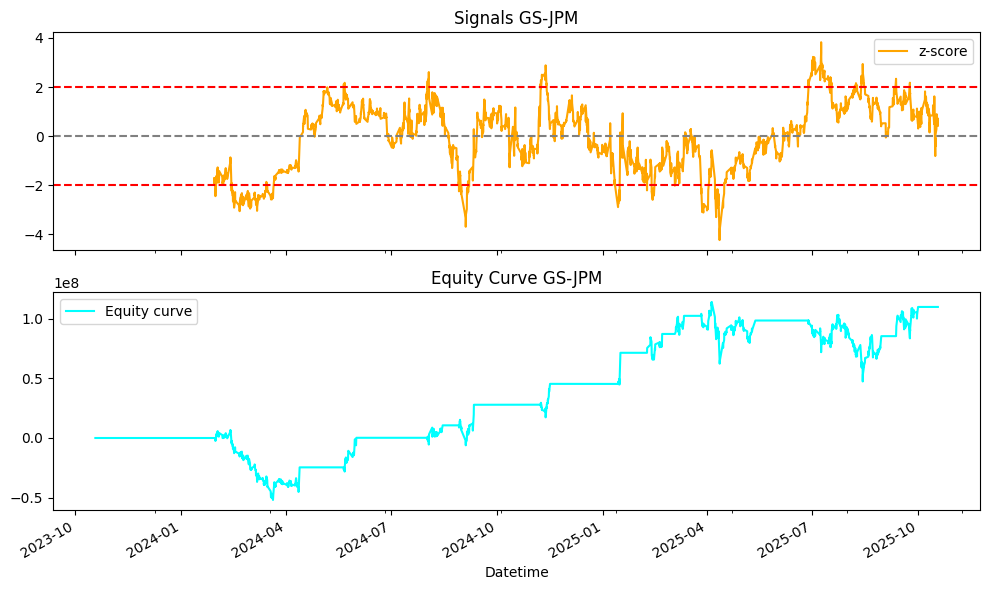

In [22]:
# =====================================
# Backtest simple par paire (corrigé)
# =====================================

def backtest_pair(prices, a, b, df_spread,
                  entry=ZSCORE_ENTRY, exit=ZSCORE_EXIT,
                  cost_bps=TRANSACTION_COST_BPS,
                  capital=CAPITAL_PER_TRADE):
    """
    Backtest simple sur une paire donnée à partir de son z-score.
    Règle :
      - Entrée quand |z| >= entry
      - Sortie quand |z| <= exit
    Renvoie un DataFrame avec signaux et PnL cumulatif.
    """
    z = df_spread["zscore"].copy()
    spread = df_spread["spread"].copy()

    # ------------------------
    # Génération des positions
    # ------------------------
    position = np.zeros(len(z))
    in_trade = 0  # 1=long spread, -1=short spread, 0=flat

    for t in range(1, len(z)):
        if in_trade == 0:
            if z.iloc[t] <= -entry:
                in_trade = 1    # long spread
            elif z.iloc[t] >= entry:
                in_trade = -1   # short spread
        elif in_trade == 1 and z.iloc[t] >= -exit:
            in_trade = 0        # sortie long
        elif in_trade == -1 and z.iloc[t] <= exit:
            in_trade = 0        # sortie short
        position[t] = in_trade

    # Convertir en Series alignée sur les index
    position = pd.Series(position, index=z.index, name="position")

    # ------------------------
    # Calcul des rendements du spread
    # ------------------------
    spread_ret = spread.diff().fillna(0)

    # ✅ On retire le signe négatif : on gagne si la position est alignée avec la variation du spread
    pnl = position.shift(1) * spread_ret

    # Coûts de transaction
    pnl -= np.abs(position.diff()) * (cost_bps / 1e4) * np.abs(spread_ret)

    df = pd.DataFrame({
        "zscore": z,
        "spread": spread,
        "position": position,
        "pnl": pnl * capital
    }, index=z.index)

    df["equity"] = df["pnl"].cumsum()
    return df



# ------------------------
# Application à toutes les paires
# ------------------------
results = {}
for name, df_sp in spreads.items():
    a, b = name.split("-")
    df_bt = backtest_pair(prices, a, b, df_sp)
    results[name] = df_bt
    print(f"✅ Backtest terminé pour {name} : PnL final = {df_bt['equity'].iloc[-1]:.0f} €")

# ------------------------
# Visualisation d'une paire exemple
# ------------------------
pair_name = list(results.keys())[0]
res = results[pair_name]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
res["zscore"].plot(ax=ax[0], color="orange", label="z-score")
ax[0].axhline(ZSCORE_ENTRY, ls="--", color="red")
ax[0].axhline(-ZSCORE_ENTRY, ls="--", color="red")
ax[0].axhline(0, ls="--", color="grey")
ax[0].set_title(f"Signals {pair_name}")
ax[0].legend()

res["equity"].plot(ax=ax[1], color="cyan", label="Equity curve")
ax[1].set_title(f"Equity Curve {pair_name}")
ax[1].legend()
plt.tight_layout()
plt.show()


In [23]:
# =====================================
# Analyse de performance par paire
# =====================================

import numpy as np
import pandas as pd

def compute_performance_stats(df, freq_per_year=252*6.5):  # 252j * 6.5h ≈ 1638 barres/an (1H data)
    """
    Calcule les métriques de performance pour un backtest donné.
    freq_per_year : nombre de barres horaires par an (utile pour annualiser le Sharpe)
    """
    pnl = df["pnl"].dropna()
    equity = df["equity"].dropna()
    ret = pnl / abs(pnl.mean() if pnl.mean()!=0 else 1)  # normalisé pour Sharpe

    # Annualisation : σ * √freq
    sharpe = (pnl.mean() / pnl.std()) * np.sqrt(freq_per_year) if pnl.std() > 0 else np.nan

    # Max drawdown
    roll_max = equity.cummax()
    drawdown = (equity - roll_max)
    max_dd = drawdown.min()

    # Nombre de trades et hit ratio
    trades = df["position"].diff().abs().sum() / 2  # entrée + sortie = 2
    trade_pnl = df.loc[df["position"].diff().abs() != 0, "pnl"]
    wins = (trade_pnl > 0).sum()
    hit_ratio = wins / len(trade_pnl) if len(trade_pnl) > 0 else np.nan

    # Durée moyenne en position (en heures)
    pos_changes = df["position"].diff().abs()
    pos_lengths = []
    current_len = 0
    for i, p in enumerate(df["position"]):
        if p != 0:
            current_len += 1
        elif current_len > 0:
            pos_lengths.append(current_len)
            current_len = 0
    mean_holding = np.mean(pos_lengths) if pos_lengths else 0

    return {
        "Final PnL (€)": equity.iloc[-1],
        "Sharpe": sharpe,
        "Max DD (€)": max_dd,
        "Trades": trades,
        "Hit Ratio": hit_ratio,
        "Avg Holding (h)": mean_holding,
    }

# ------------------------
# Calcul des stats pour toutes les paires
# ------------------------
perf = {}
for name, df_bt in results.items():
    perf[name] = compute_performance_stats(df_bt)

perf_df = pd.DataFrame(perf).T.sort_values("Final PnL (€)", ascending=False)
display(perf_df.round(3))

# Sauvegarde
out_path = Path(OUTPUT_DIR) / "performance_summary.parquet"
perf_df.to_parquet


,Final PnL (€),Sharpe,Max DD (€),Trades,Hit Ratio,Avg Holding (h)
GS-JPM,1.098060e+08,0.832,-6.652333e+07,11.0,0.478,118.273
JPM-WFC,5.559366e+07,0.850,-4.017135e+07,12.0,0.480,114.167
BK-GS,8.546043e+05,0.043,-1.475752e+07,6.0,0.462,180.167


<bound method DataFrame.to_parquet of          Final PnL (€)    Sharpe    Max DD (€)  Trades  Hit Ratio  \
GS-JPM    1.098060e+08  0.831681 -6.652333e+07    11.0   0.478261   
JPM-WFC   5.559366e+07  0.850213 -4.017135e+07    12.0   0.480000   
BK-GS     8.546043e+05  0.042996 -1.475752e+07     6.0   0.461538   

         Avg Holding (h)  
GS-JPM        118.272727  
JPM-WFC       114.166667  
BK-GS         180.166667  >

C:\Users\Emile\AppData\Local\Temp\ipykernel_21020\115359432.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity_portfolio = pd.concat(equities, axis=1).fillna(method="ffill").fillna(0)


=== Statistiques globales du portefeuille ===
Final PnL (€)   : 166,254,219.70
Sharpe          : 1.07
Max DD (€)      : -74,056,325.58


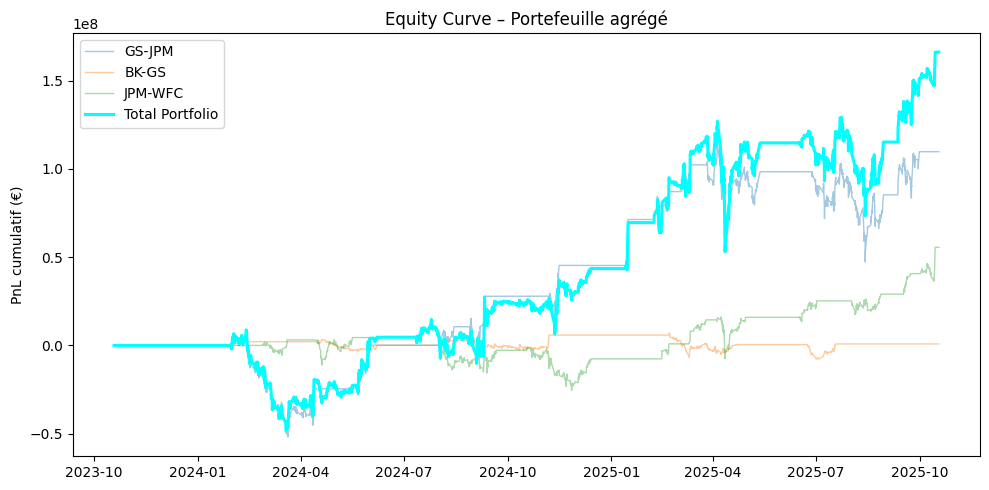

✅ Courbe d’equity sauvegardée : ..\data\processed\backtest_results\portfolio_equity.parquet


In [24]:
# =====================================
# Performance du portefeuille agrégé
# =====================================

import matplotlib.pyplot as plt

# ------------------------
# Construction de la courbe d’equity globale
# ------------------------
equities = []
for name, df_bt in results.items():
    eq = df_bt["equity"].rename(name)
    equities.append(eq)

# Aligne les index temporels et somme les equity
equity_portfolio = pd.concat(equities, axis=1).fillna(method="ffill").fillna(0)
equity_portfolio["Portfolio"] = equity_portfolio.sum(axis=1)


# ------------------------
# Calcul des métriques globales
# ------------------------
def compute_portfolio_stats(eq):
    pnl = eq.diff().fillna(0)
    mean, std = pnl.mean(), pnl.std()
    sharpe = (mean / std) * np.sqrt(252 * 6.5) if std > 0 else np.nan
    roll_max = eq.cummax()
    drawdown = eq - roll_max
    max_dd = drawdown.min()
    return {
        "Final PnL (€)": eq.iloc[-1],
        "Sharpe": sharpe,
        "Max DD (€)": max_dd,
    }


port_stats = compute_portfolio_stats(equity_portfolio["Portfolio"])
print("=== Statistiques globales du portefeuille ===")
for k, v in port_stats.items():
    print(f"{k:<15} : {v:,.2f}")

# ------------------------
# Visualisation
# ------------------------
fig, ax = plt.subplots(figsize=(10, 5))
for c in equity_portfolio.columns[:-1]:
    ax.plot(equity_portfolio.index, equity_portfolio[c], alpha=0.4, lw=1, label=c)
ax.plot(equity_portfolio.index, equity_portfolio["Portfolio"], color="cyan", lw=2.2, label="Total Portfolio")

ax.set_title("Equity Curve – Portefeuille agrégé")
ax.set_ylabel("PnL cumulatif (€)")
ax.legend()
plt.tight_layout()
plt.show()

# Sauvegarde des equity curves
out_path = Path(OUTPUT_DIR) / "portfolio_equity.parquet"
equity_portfolio.to_parquet(out_path)
print(f"✅ Courbe d’equity sauvegardée : {out_path}")


===== RAPPORT FINAL – PAIRS TRADING =====


,Final PnL (€),Sharpe,Max DD (€),Trades,Hit Ratio,Avg Holding (h)
GS-JPM,"109,805,957.68",0.83,"-66,523,334.31",11.00,0.48,118.27
JPM-WFC,"55,593,657.68",0.85,"-40,171,353.62",12.00,0.48,114.17
BK-GS,"854,604.34",0.04,"-14,757,523.13",6.00,0.46,180.17
Portfolio,"166,254,219.70",1.07,"-74,056,325.58",nan,nan,nan


C:\Users\Emile\AppData\Local\Temp\ipykernel_21020\1485138905.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=report_df.reset_index(), x="index", y="Final PnL (€)", ax=ax, palette="crest")


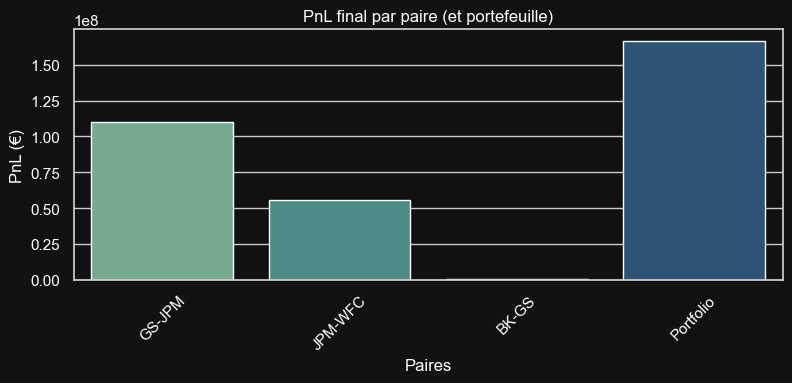

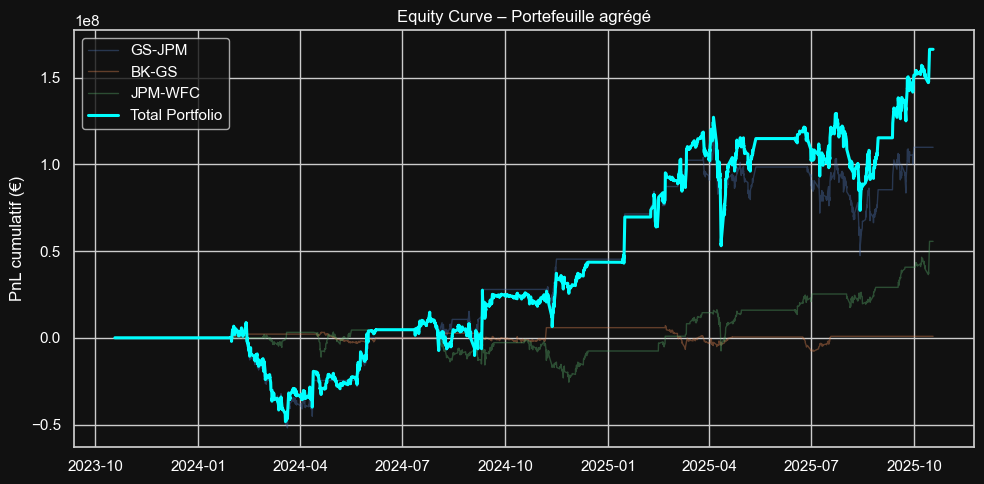

✅ Rapport sauvegardé :
- ..\data\processed\backtest_results\rapport_performance.html
- ..\data\processed\backtest_results\rapport_equity.png


In [25]:
# =====================================
# Rapport de synthèse – Backtest Pairs Trading
# =====================================

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid", rc={"axes.facecolor": "#111111", "figure.facecolor": "#111111",
                               "axes.labelcolor": "white", "text.color": "white",
                               "xtick.color": "white", "ytick.color": "white"})

# -------------------------------------
# 1️⃣ Récapitulatif global
# -------------------------------------
report_df = perf_df.copy()
report_df.loc["Portfolio"] = [
    port_stats["Final PnL (€)"],
    port_stats["Sharpe"],
    port_stats["Max DD (€)"],
    np.nan, np.nan, np.nan
]

print("===== RAPPORT FINAL – PAIRS TRADING =====")
display(report_df.style.format("{:,.2f}").set_table_styles(
    [{"selector": "th", "props": [("color", "white"), ("background-color", "#333")]},
     {"selector": "td", "props": [("background-color", "#222")]}]
))

# -------------------------------------
# 2️⃣ Graphique comparatif du PnL final
# -------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=report_df.reset_index(), x="index", y="Final PnL (€)", ax=ax, palette="crest")
ax.set_title("PnL final par paire (et portefeuille)", fontsize=12)
ax.set_xlabel("Paires")
ax.set_ylabel("PnL (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------------
# 3️⃣ Courbe d’equity du portefeuille
# -------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))
for c in equity_portfolio.columns[:-1]:
    ax.plot(equity_portfolio.index, equity_portfolio[c], alpha=0.4, lw=1, label=c)
ax.plot(equity_portfolio.index, equity_portfolio["Portfolio"], color="cyan", lw=2.2, label="Total Portfolio")
ax.set_title("Equity Curve – Portefeuille agrégé", fontsize=12)
ax.set_ylabel("PnL cumulatif (€)")
ax.legend()
plt.tight_layout()
plt.show()

# -------------------------------------
# 4️⃣ Export du rapport
# -------------------------------------
report_dir = Path(OUTPUT_DIR)
report_dir.mkdir(parents=True, exist_ok=True)
report_path_html = report_dir / "rapport_performance.html"
report_path_png = report_dir / "rapport_equity.png"

# Sauvegarde graphique principal
fig.savefig(report_path_png, dpi=200, bbox_inches="tight")

# Sauvegarde tableau HTML
report_df.to_html(report_path_html, float_format="%.2f")

print(f"✅ Rapport sauvegardé :\n- {report_path_html}\n- {report_path_png}")
